# Prior Predictive Modeling

This guide provides an introduction to prior predictive modeling using PyMC (and PyMC Marketing) and the {class}`Prior <pymc_marketing.prior.Prior>` class from PyMC-Marketing. Before diving into the technical details, let's understand why priors are crucial in Bayesian analysis and their practical importance in industry applications.

## Understanding Bayesian Inference

Bayesian inference is based on Bayes' theorem, which provides a formal way to update our beliefs about parameters $\theta$ (say, saturation or decay rate in a marketing mix models) given observed data $y$:

$$p(\theta|y) = \frac{p(y|\theta)p(\theta)}{p(y)}$$

Where:
- $p(\theta|y)$ is the posterior probability (what we want to learn)
- $p(y|\theta)$ is the likelihood (how the data is generated)
- $p(\theta)$ is the prior probability (our initial beliefs)
- $p(y)$ is the evidence (a normalizing constant), which can be written as $p(y) = \displaystyle{ \int p(y|\theta)p(\theta)d\theta }$

The posterior distribution combines our prior knowledge with the observed data to give us updated beliefs about the parameters. In practice, we often work with the unnormalized posterior:

$$p(\theta|y) \propto p(y|\theta)p(\theta)$$

This is because the normalizing constant $p(y)$ is often intractable to compute directly.

### Why Priors Matter in Industry

In industry applications, priors serve several crucial purposes:

1. **Domain Knowledge Integration**:
   - Incorporating expert knowledge into models
   - Leveraging historical data from similar projects
   - Encoding business constraints and requirements

2. **Risk Management**:
   - Preventing unrealistic predictions
   - Ensuring stable model behavior
   - Managing uncertainty in decision-making

3. **Data Efficiency**:
   - Making models work with limited data
   - Faster convergence to reasonable solutions
   - Robust predictions in new scenarios

4. **Model Regularization**:
   - Preventing overfitting
   - Handling multicollinearity
   - Dealing with sparse data

### Common Prior Specification Scenarios

In marketing analytics, you'll often encounter these scenarios:

1. **Marketing Mix Models**:
   - Media channel effectiveness (typically positive)
   - Diminishing returns (shape constraints)
   - Lift tests calibration

2. **Customer Lifetime Value**:
   - Purchase rates (positive values)
   - Churn probabilities (between 0 and 1)
   - Monetary value distributions (positive, often log-normal)

3. **A/B Testing**:
   - Conversion rates (bounded between 0 and 1)
   - Lift measurements (centered around small effects)
   - Revenue impacts (potentially heavy-tailed)

## What is Prior Predictive Modeling?

Prior predictive modeling is a crucial step in Bayesian workflow that helps us validate our prior choices before seeing the actual data. The process involves:

1. **Specification**: 
   - Define prior distributions for model parameters
   - Encode domain knowledge and constraints
   - Document assumptions and choices

2. **Simulation**:
   - Sample parameters from prior distributions
   - Generate synthetic data using the model structure
   - Create multiple scenarios of possible outcomes

3. **Validation**:
   - Check if simulated data matches domain expertise
   - Verify that impossible scenarios are excluded
   - Ensure reasonable coverage of possible outcomes

### Benefits in Practice

1. **Early Problem Detection**:
   - Identify unrealistic assumptions
   - Catch numerical issues before model fitting
   - Validate model structure

2. **Stakeholder Communication**:
   - Visualize model implications
   - Justify modeling choices
   - Set realistic expectations

3. **Model Development**:
   - Iterate on prior choices efficiently
   - Compare alternative specifications
   - Document model evolution

4. **Risk Assessment**:
   - Understand model limitations
   - Identify edge cases
   - Plan for failure modes

The prior predictive distribution $p(y)$ represents our beliefs about the data before we observe it. Mathematically, it's the distribution of the data marginalized over the prior:

$$p(y) = \int p(y|\theta)p(\theta)d\theta$$

In practice, we can sample from this distribution by:
1. Drawing parameters from the prior: $\theta^{(s)} \sim p(\theta)$
2. Generating data from the likelihood: $y^{(s)} \sim p(y|\theta^{(s)})$

This process helps us validate our model in several ways:

1. **Parameter Space Coverage**: 
   The samples $\{\theta^{(s)}\}_{s=1}^S$ show us what parameter values we consider plausible

2. **Data Space Coverage**: 
   The samples $\{y^{(s)}\}_{s=1}^S$ show us what data our model can generate

3. **Model Sensitivity**: 
   The relationship between $\theta^{(s)}$ and $y^{(s)}$ shows how parameters influence predictions

Let's explore these concepts through practical examples using the {class}`Prior <pymc_marketing.prior.Prior>` class from PyMC-Marketing.


## Prepare Notebook

In [11]:
import warnings
from numpy.typing import NDArray
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymc_marketing.prior import Prior


seed: int = sum(map(ord, "prior"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple Example: Normal Distribution

Let's start with a simple example using a normal distribution. We'll:
1. Generate a synthetic dataset
2. Study the observed distribution
3. Set a prior for the mean and standard deviation
4. Sample from its prior predictive distribution


First we generate a synthetic dataset from a normal distribution with mean one and standard deviation two.

In [19]:
true_mu: float = 1.0
true_sigma: float = 2.0
n_observations: int = 50

data: NDArray = rng.normal(loc=true_mu, scale=true_sigma, size=n_observations)

sample_mean: float = data.mean()
sample_std: float = data.std()

Let's visualize the observed data.



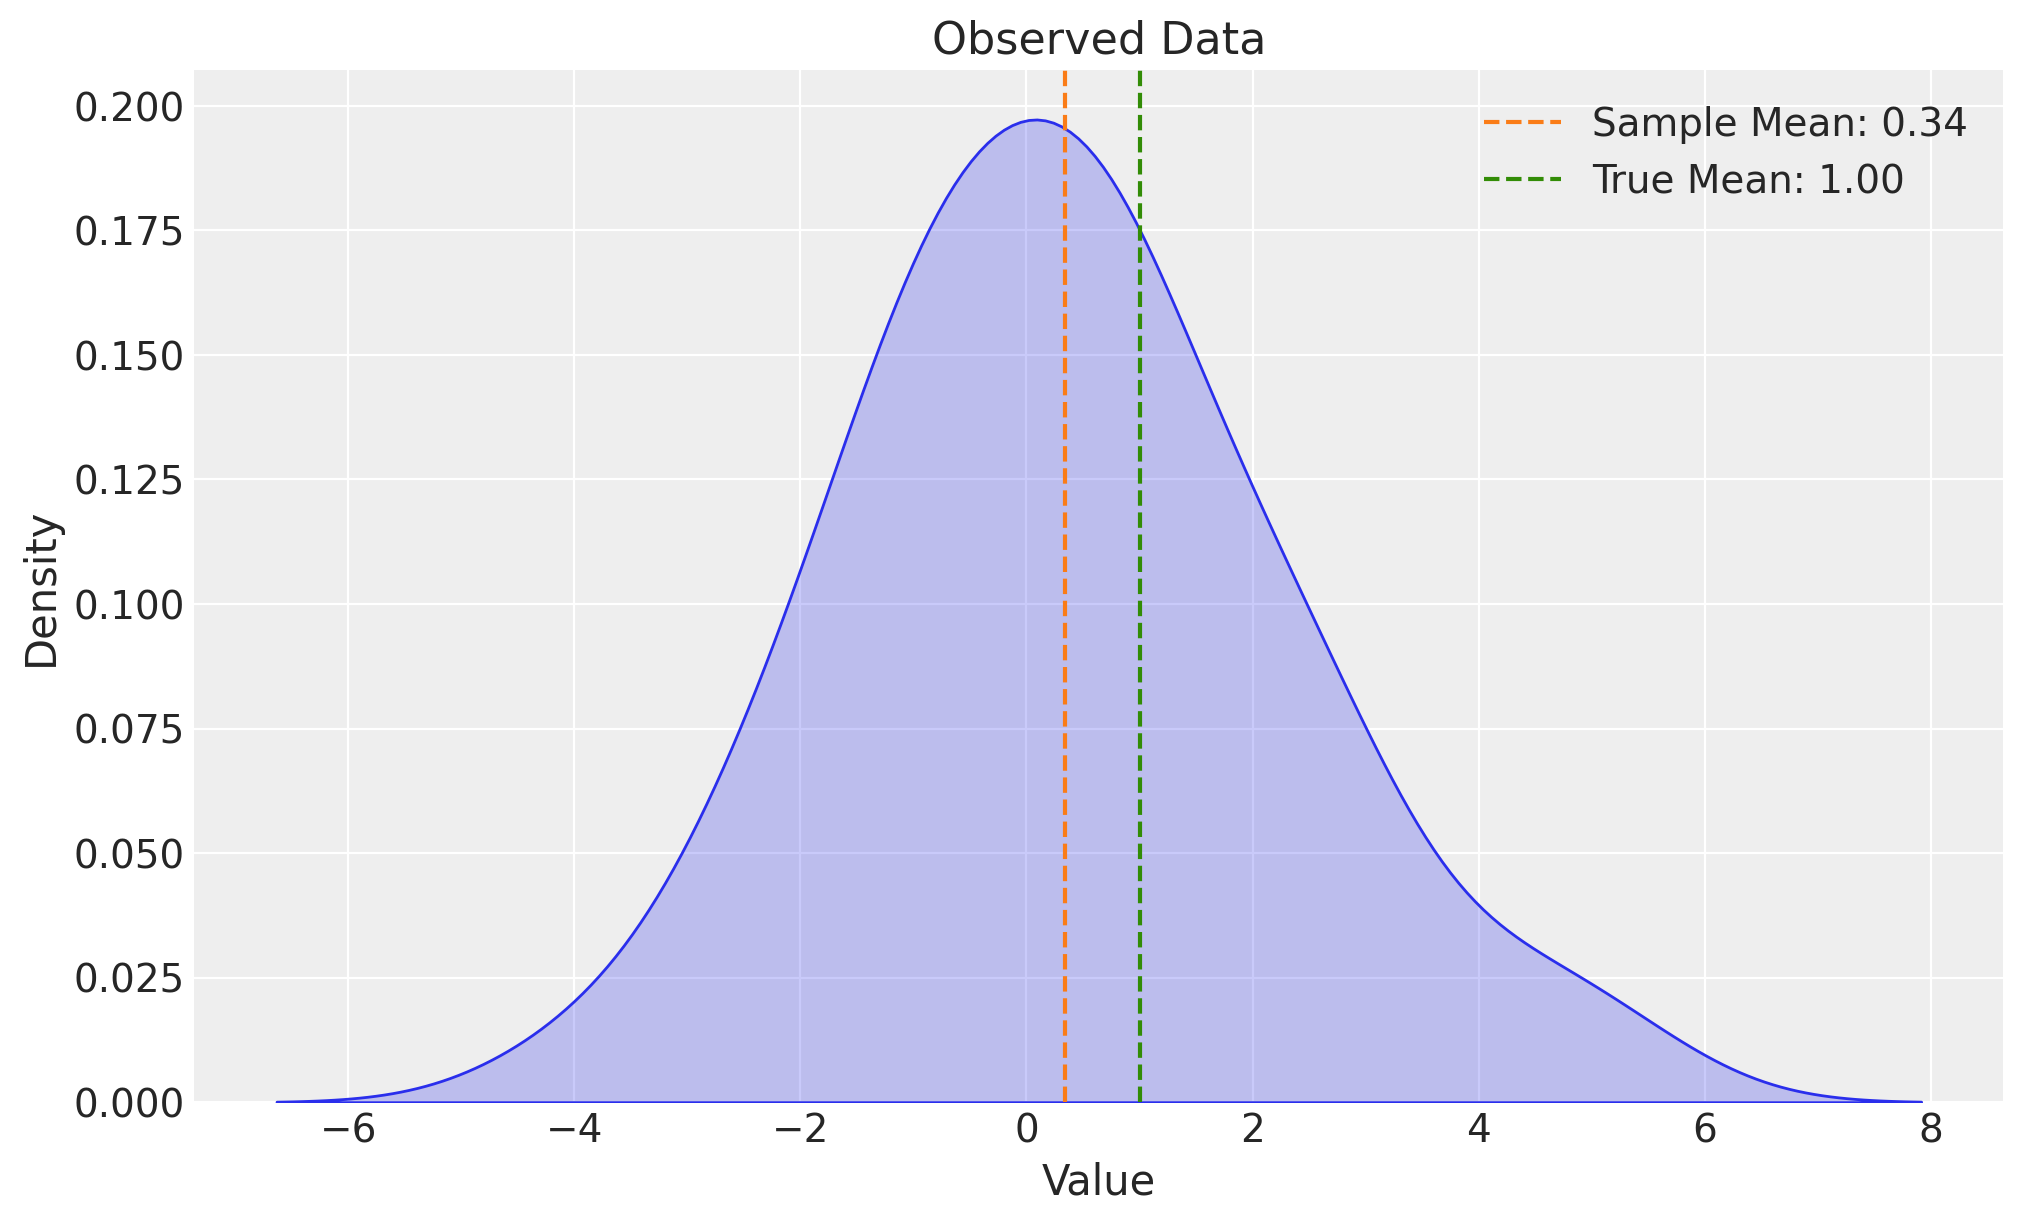

In [24]:
fig, ax = plt.subplots()
sns.kdeplot(data, fill=True, ax=ax)
ax.axvline(
    sample_mean, color="C1", linestyle="--", label=f"Sample Mean: {sample_mean:.2f}"
)
ax.axvline(true_mu, color="C2", linestyle="--", label=f"True Mean: {true_mu:.2f}")
ax.legend()
ax.set(title="Observed Data", xlabel="Value", ylabel="Density");

We are going to assume we do not know the true mean and standard deviation of the data (as in almost all cases). Our idea is to fit a bayesian model to try to recover the true parameters.

We are going to assume the parametric form:

$$
y \sim \text{Normal}(\mu, \sigma)
$$

What could be sensible priors for the mean and standard deviation?


Sampling: [var]


AttributeError: 'function' object has no attribute 'values'

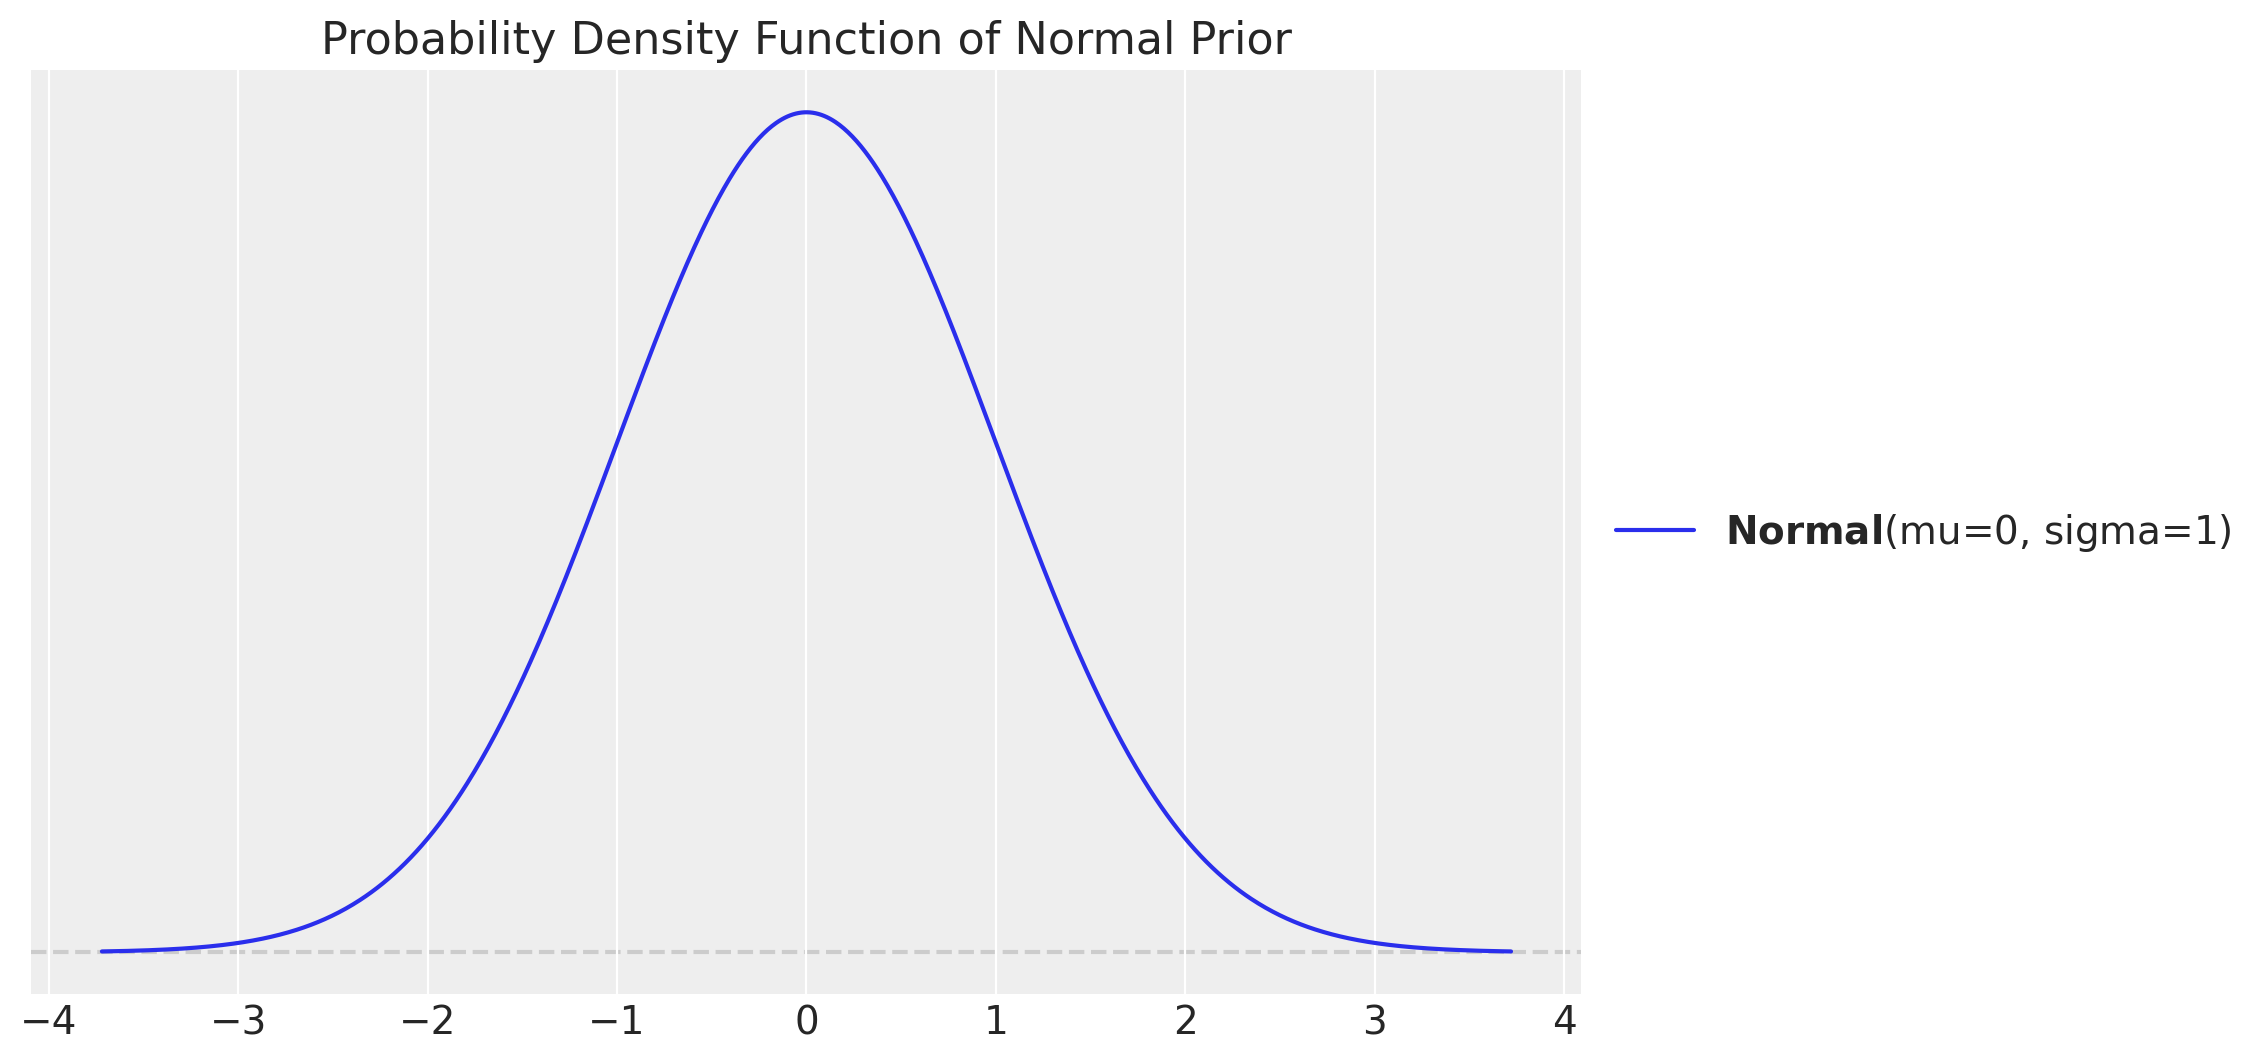

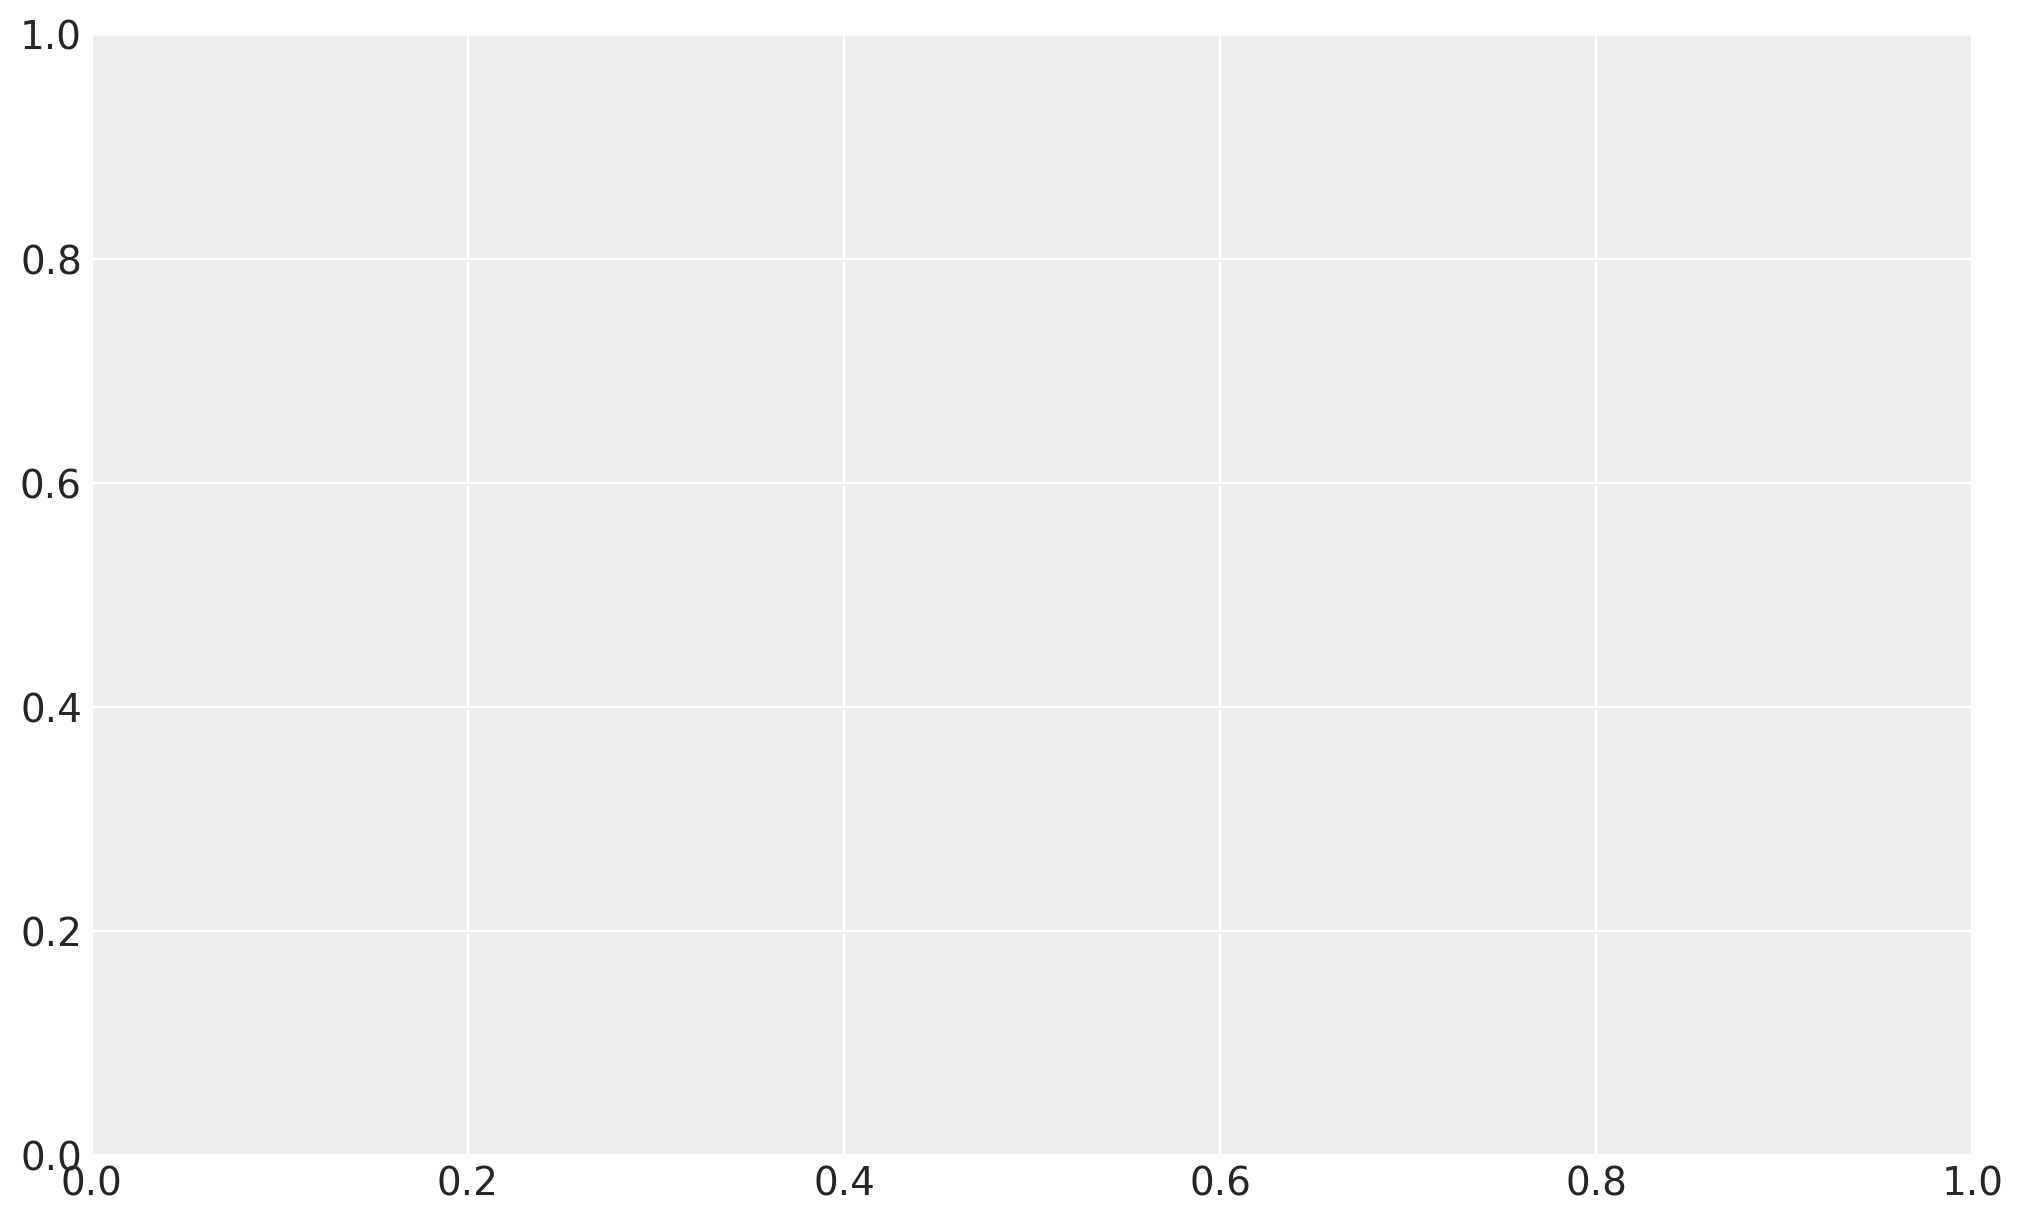

In [25]:
# Create a normal prior with mean 0 and standard deviation 1
normal_prior = Prior("Normal", mu=0, sigma=1)

# Plot the PDF of the prior
fig, ax = plt.subplots(figsize=(10, 6))
normal_prior.preliz.plot_pdf(ax=ax)
ax.set_title("Probability Density Function of Normal Prior")

# Sample from the prior predictive distribution
samples = normal_prior.sample_prior(samples=1000)

# Plot histogram of samples
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(samples.var.values, bins=30, density=True, alpha=0.7)
ax.set_title("Prior Predictive Samples")
ax.set_xlabel("Value")
ax.set_ylabel("Density")